Stochastic 1D 
=====
***

A one-dimensional stochastic model for the dipole field $x(t)$. The field is generated by a series of impulsive (delta function) events. The event time follows a Poisson process and the event amplitude has a uniform distribution $U(a,b)$.  A small number of negative (destructive) events are permitted by adopting a negative lower limit (a<0), but the average amplitude must be position to sustain the field against diffusive losses. The variance of the dipole moment depends on the range $b-a$. A white noise source with mean 0 and variance $q$ is added to the equation for $x(t)$.

In [21]:
using Plots
using Distributions
using StatsBase
using DelimitedFiles

Draw event times from an exponential distribution

mean recurrence time = 0.003032602120362753 Myr


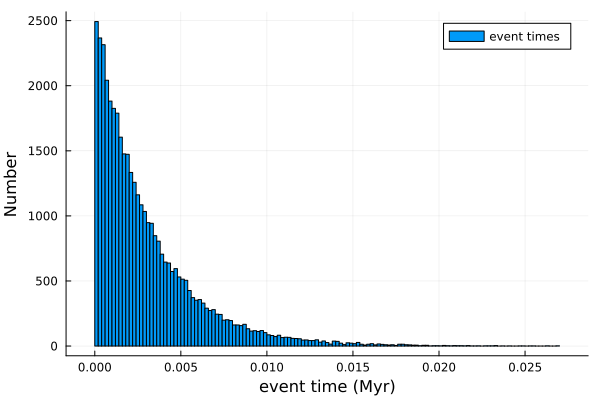

In [22]:
myr = 1.0e6;
recurrence = 3030/myr;         # average recurrence time (Myr)
nevents = 40000;
tevent = rand(Exponential(recurrence),nevents);  # Poisson event times

# plot distribution of event times
println("mean recurrence time = ",mean(tevent)," Myr")
histogram(tevent,label="event times",xlabel="event time (Myr)",ylabel="Number")

Specify and sample distribution of event amplitudes

In [23]:

Amax = 0.455
Amin = -0.13
amp_p = rand(Uniform(Amin,Amax),nevents)

# include random (white) noise
np = rand(Normal(),2*nevents); #called wi in paper
qp = 45;       #  gaussian noise variance

# set level of quenching
x0 = 5.0;

Integrate equations for dipole field. Each event interval $\Delta t$ is divided into two parts. Diffusion causes the dipole to decrease during $\Delta t/2$. Diffusion and a single source event contribute to $x(t)$ over second half of the event interval. Gaussian noise is added at each half time step.

In [4]:
# allocate memory for solution
x = zeros(2*nevents);
t = zeros(2*nevents);


# decay rate for dipole (gamma = 1/tau)
gamma = 0.025 * 1000;    # convert to Myr

# initial condition
t[1] = 0.0;
x[1] = 5.0;
j = 2;

# integrate of number of events
for i = j : nevents
    
    # magnetic diffusion over half time step dt
    dt = tevent[i]/2.0;
    t[j] = t[j-1] + dt;
    gp = exp(-x[j-1]^2/1.8^2);  # x-dependence of gaussian noise
    x[j] = x[j-1] * exp(-gamma * dt) + np[j]*sqrt(gp*qp*dt);;
    
    # magnetic diffusion over remaining time step
    j += 1;
    t[j] = t[j-1] + dt;
    x[j] = x[j-1] * exp(-gamma * dt)
    
    # evaluate quenching
    fp = 1.0/ (1.0 + (x[j]/x0)^2);
    gp = exp(-x[j]^2/1.8^2);
    
    # add event and random noise
    x[j] += amp_p[i] * x[j] * fp + np[j]*sqrt(gp*qp*dt); 
    j+= 1;
    
end
t[end] = t[end-1]
x[end] = x[end-1]
println("mean x = ",mean(abs.(x))," std x = ",std(abs.(x)))

mean x = 5.472822124888696 std x = 1.553430027676392


In [34]:
for Amax in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.2, 1.4, 1.6, 2.0]
    Amin = -0.13
    amp_p = rand(Uniform(Amin,Amax),nevents)

    # include random (white) noise
    np = rand(Normal(),2*nevents); #called wi in paper
    qp = 45;       #  gaussian noise variance
    
    # set level of quenching
    x0 = 5.0;

    # allocate memory for solution
    x = zeros(2*nevents);
    t = zeros(2*nevents);
    
    
    # decay rate for dipole (gamma = 1/tau)
    gamma = 0.025 * 1000;    # convert to Myr
    
    # initial condition
    t[1] = 0.0;
    x[1] = 5.0;
    j = 2;
    
    # integrate of number of events
    for i = j : nevents
        
        # magnetic diffusion over half time step dt
        dt = tevent[i]/2.0;
        t[j] = t[j-1] + dt;
        gp = exp(-x[j-1]^2/1.8^2);  # x-dependence of gaussian noise
        x[j] = x[j-1] * exp(-gamma * dt) + np[j]*sqrt(gp*qp*dt);;
        
        # magnetic diffusion over remaining time step
        j += 1;
        t[j] = t[j-1] + dt;
        x[j] = x[j-1] * exp(-gamma * dt)
        
        # evaluate quenching
        fp = 1.0/ (1.0 + (x[j]/x0)^2);
        gp = exp(-x[j]^2/1.8^2);
        
        # add event and random noise
        x[j] += amp_p[i] * x[j] * fp + np[j]*sqrt(gp*qp*dt); 
        j+= 1;
        
    end
    t[end] = t[end-1]
    x[end] = x[end-1]
    println("Amax = " , Amax, " mean x = ",mean(abs.(x))," std x = ",std(abs.(x)))
end


Amax = 0.2 mean x = 0.958296230681996 std x = 0.6480051657626619
Amax = 0.3 mean x = 2.0019790846491157 std x = 1.1666357606260451
Amax = 0.4 mean x = 4.348131032885902 std x = 1.5224880617909016
Amax = 0.5 mean x = 6.098631324896151 std x = 1.6128136539530902
Amax = 0.6 mean x = 7.575489801043707 std x = 1.679717304378693
Amax = 0.7 mean x = 8.793106754236515 std x = 1.8064283749201904
Amax = 0.8 mean x = 9.73885722838526 std x = 1.9052542919281648
Amax = 1.2 mean x = 13.079213273494815 std x = 2.3036380913162557
Amax = 1.4 mean x = 14.504731914468456 std x = 2.4426469788096017
Amax = 1.6 mean x = 15.692733112325644 std x = 2.603065150119826
Amax = 2.0 mean x = 17.941022524817143 std x = 2.858403759366919


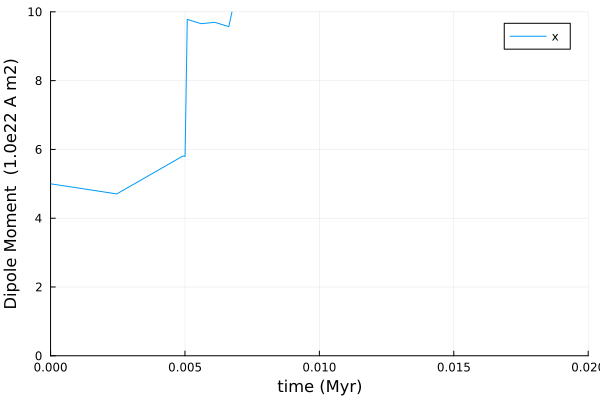

In [37]:
# print time series 
idecimate = 1;
plot(t[1:idecimate:end],(x[1:idecimate:end]),
    label="x",xlabel="time (Myr)",
    ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,0.02),
    ylim=(0,10)
)

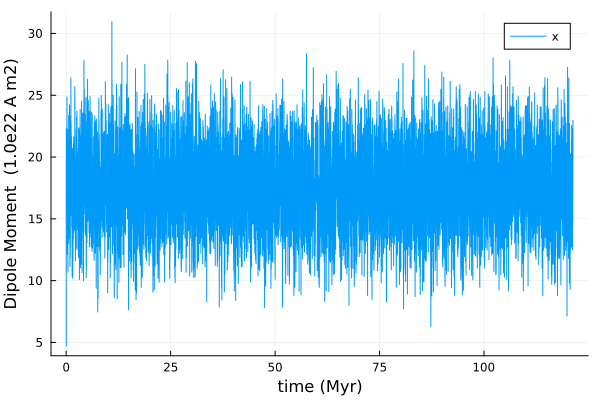

In [38]:
# print time series 
idecimate = 1;
plot(t[1:idecimate:end],(x[1:idecimate:end]),
    label="x",xlabel="time (Myr)",
    ylabel="Dipole Moment  (1.0e22 A m2)"
)

In [29]:
# save to file ?
save_file = true
      
if save_file
    open("dipole_3000.txt","w")  do io
        writedlm(io,[t x])
    end
end

Plot a histogram of dipole moment

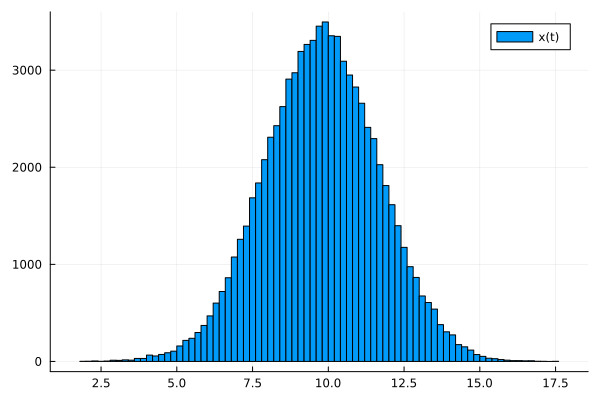

In [30]:
h = fit(Histogram,x,nbins=100)
plot(h,label="x(t)")

Evaluates the mean amplitudes $<A>$, $<A^2>$ and $<A^3>$. Mean and second moment appear in the Fokker-Planck equation.

In [9]:
function moments(A,rate)
#
# evaluates moments of amplitudes <A>, <A2>, <A3>.
#
# input
# A  - nominal amplitude of events
# rate - rate of Poisson process

# output
# Ap  - moments of amplitudes Ap[1st,2nd,3rd]

# maximum and minimum amplitudes
Apmin = 0.47 * A;   #close to earlier values
Apmax = 4.14 * A;

An = zeros(3);

An[1] = rate*(Apmin+Apmax)/2.0;
An[2] = rate*(Apmax^2 + Apmin^2 + Apmax*Apmin)/3.0;
An[3] = rate*(Apmax + Apmin)*(Apmax^2+Apmin^2)/4.0;



return An

end


moments (generic function with 1 method)

Compute drift $D_1$ and diffusion $D_2$ coefficients

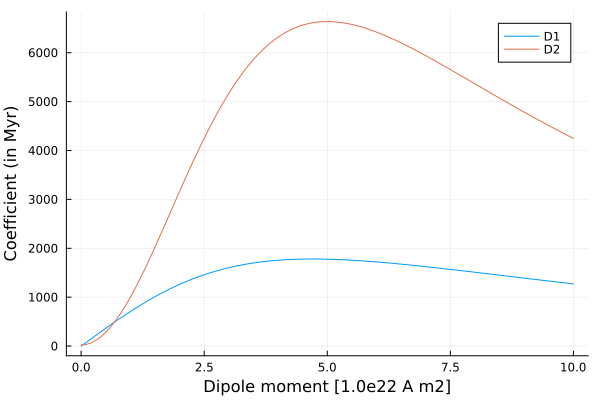

In [10]:
rate = 1/recurrence
An = moments(A,rate)

# define range of x for plotting
xplot = (0 : 0.1 : 10.0);
D1 = zeros(length(xplot))
D2 = zeros(length(xplot))
D3 = zeros(length(xplot))

# compute D1 and D2 at plotting points
for i = 1 : length(xplot)
    f = 1.0 / (1.0 + (xplot[i]/x0)^2);
    g = exp(-xplot[i]^2/1.8^2)
    D1[i] = -gamma*xplot[i] + An[1]*xplot[i]*f;
    D2[i] = 0.5*An[2]*(xplot[i]^2)*(f^2) + 0.5 * qp*g;
    D3[i] = (1/6.0) * An[3]*(xplot[i]^3)*(f^3);
end

plot(xplot,D1,label="D1",xlabel="Dipole moment [1.0e22 A m2]",ylabel="Coefficient (in Myr)")
plot!(xplot,D2,label="D2")
#plot(xplot,D3)

Save a plot of the drift and diffusion coefficients

In [11]:
savefig("Drift&Diffusion.pdf")

In [12]:
using Interpolations

function resample_linear(t::Vector{Float64}, x::Vector{Float64},
                         dt::Float64)

    # Create linear interpolation
    itp = LinearInterpolation(t, x, extrapolation_bc=Line())

    # Create uniform time vector using sampling frequency
    t_min = first(t)
    t_max = last(t)
    t_uniform = collect(t_min:dt:t_max)

    # Interpolate x at uniform time points
    x_uniform = itp.(t_uniform)

    return t_uniform, x_uniform
end

resample_linear (generic function with 1 method)

In [13]:
t_resampled, x_resampled = resample_linear(t, x, 0.01)

Excessive output truncated after 1543977 bytes.

([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  120.7, 120.71000000000001, 120.72, 120.73, 120.74000000000001, 120.75, 120.76, 120.77, 120.78, 120.79], [5.0, 5.865506377046873, 5.167221831688497, 5.743512731431474, 4.773209493289352, 3.6790138069675153, 3.2748060017717204, 5.209279295477796, 6.112954139794663, 6.2144661070276035  …  5.969334578499848, 6.776020044682923, 6.176868220446458, 6.449625194784964, 6.415509449502941, 7.175531736070378, 7.760324203566085, 5.85692603144553, 4.182177718721261, 3.913530247060405])

In [14]:
open("dipole_3000_resampled_mod2_10kyr.txt","w")  do io
    writedlm(io,[t_resampled x_resampled])
end

In [15]:
function convert_VDM_to_g10(vdm::Float64)
    #Earth's radius is 6371.2 km
    g10 = vdm *1e-7/(6371200.0^3)
    return g10
end

convert_VDM_to_g10 (generic function with 1 method)

In [31]:
function convert_g10_to_VDM(g10::Float64)
    #Earth's radius is 6371.2 km
    vdm  = g10 *(6371200.0^3)*1e7
    return vdm
end

convert_g10_to_VDM (generic function with 1 method)

In [16]:
g10 = x_resampled *1.0e22 *1.0e-7/(6371200.0^3)* 1.0e6 #returns values in microT

12080-element Vector{Float64}:
 19.333313320921366
 22.67993451466191
 19.979903734147786
 22.208226239893115
 18.456390936031873
 14.22550532841974
 12.662570099497291
 20.14252575913215
 23.63673154021472
 24.02924407388222
 23.12590178617694
 23.841832760268257
 20.43781767697019
  ⋮
 16.818716019087255
 19.17706116900029
 23.08140314470953
 26.200583718539715
 23.883865729586677
 24.938524938657245
 24.806610860114425
 27.745360659532693
 30.006555859894537
 22.6467572126794
 16.171070439962858
 15.132301291464325

In [17]:
open("dipole_3000_resampled_mod2_10kyr.txt","w")  do io
    writedlm(io,[t_resampled g10])
end

In [18]:
convert_VDM_to_g10(5.38)

2.0802645133311393e-27

In [19]:
convert_VDM_to_g10(5.377)

2.0791045145318837e-27

In [20]:
convert_VDM_to_g10(1.53621090158798)

5.940009337483103e-28

In [33]:
convert_g10_to_VDM(10.80e-6)

2.7931063394893824e22